As part of the 2020 Google Summer of Code, Shrey Aryan (Github: @shrey183) added new versions of the SmilesMolSupplier 
and SDMolSupplier to the RDKit which are capable of taking advantage of the multiple cores present on modern CPUs by reading multiple molecules at once. Aside from a passing mention in [a blog post a few years ago](https://greglandrum.github.io/rdkit-blog/posts/2020-11-18-sphere-exclusion-clustering.html), I have never really discussed these. This blog post aims to clear that up.

The `MultithreadedSDMolSupplier` and `MultithreadedSmilesMolSupplier` are intended to be drop-in replacements for `SDMolSupplier` and `SmilesMolSupplier`. They should take all of the same arguments and can be used more or less the same way in your code. Both classes take an additional keyword argument, `numWriterThreads`, which controls the number of molecules which can be read in parallel. The default value of `numWriterThreads` is 1 (not using more than one thread unless you ask for it is standard practice in the RDKit; I suppose we can/should consider revisiting that in this case). The major difference in usage is that the multi-threaded  suppliers are not guaranteed to return the molecules in the same order they are found in the input file; the molecules are returned in the order in which processing is finished. There's more on this below.

As a final aside: please note that, [as the documentation says](https://www.rdkit.org/docs/source/rdkit.Chem.rdmolfiles.html#rdkit.Chem.rdmolfiles.MultithreadedSDMolSupplier) the API for using the two multithreaded suppliers should still be considered to be experimental and, as such, could change a bit between releases.

The other part of Shrey's project was a "generalized file reader" that makes it easier to read 
molecules from standard input file types by trying to automatically determine the type of the file.
Shrey ran out of time to do the python wrappers for that and I still haven't managed to do it myself... 
that's a ToDo for me.

If you're interested in more details about Shrey's project, the pull request has a [summary of the GSoC project](https://github.com/rdkit/rdkit/pull/3363).


In [1]:
from rdkit import Chem

import rdkit
print(rdkit.__version__)

import matplotlib.pylab as plt
%matplotlib inline

2023.09.2


In [2]:
filename = '/scratch/RDKit_git/Regress/Data/znp.50k.smi'

Simple example of reading all molecules from the file:

In [3]:
ms = [m for m in Chem.MultithreadedSmilesMolSupplier(filename,numWriterThreads=5) if m is not None]

This is significantly faster than using a standard `SmilesMolSupplier`:

In [4]:
%timeit ms = [m for m in Chem.SmilesMolSupplier(filename) if m is not None]

6.33 s ± 47.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
%timeit ms = [m for m in Chem.MultithreadedSmilesMolSupplier(filename,numWriterThreads=5) if m is not None]

1.41 s ± 9.41 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Here's a demo of using the multithreaded supplier in a filter: only returning the molecules which match a substructure query.

In [6]:
qry = Chem.MolFromSmarts('Fc1[c,n]cccc1')

In [7]:
%timeit ms = [m for m in Chem.SmilesMolSupplier(filename) if m is not None and m.HasSubstructMatch(qry)]

7.02 s ± 31.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
%timeit ms = [m for m in Chem.MultithreadedSmilesMolSupplier(filename,numWriterThreads=5) if m is not None and m.HasSubstructMatch(qry)]

1.44 s ± 20.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The same thing works for SDF files:

In [9]:
sdfilename = '/scratch/RDKit_git/Regress/Data/znp.50k.sdf'

In [10]:
%timeit ms = [m for m in Chem.SDMolSupplier(sdfilename) if m is not None]

7.24 s ± 11.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%timeit ms = [m for m in Chem.MultithreadedSDMolSupplier(sdfilename,numWriterThreads=5) if m is not None]

1.94 s ± 75.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Another demo of generating fingerprints faster:

In [12]:
from rdkit.Chem import rdFingerprintGenerator
fpg = rdFingerprintGenerator.GetMorganGenerator()

In [13]:
%timeit fps = [fpg.GetFingerprint(m) for m in Chem.SmilesMolSupplier(filename) if m is not None]

10.9 s ± 37.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
%timeit fps = [fpg.GetFingerprint(m) for m in Chem.MultithreadedSmilesMolSupplier(filename,numWriterThreads=5) if m is not None]

4.81 s ± 72.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Of course the differences here are less dramatic since the speedup only happens for reading the molecules; we're still generating the fingerprints themselves in a single thread.

In [15]:
import time
times = {}
for nthreads in range(1,11):
    t1 = time.time()
    k = [m.GetNumAtoms() for m in Chem.MultithreadedSmilesMolSupplier(filename,numWriterThreads=nthreads) if m is not None]
    t2 = time.time()
    times[nthreads] = t2-t1
    print(f'{nthreads} threads, {t2-t1:.1f} seconds')

1 threads, 6.6 seconds
2 threads, 3.4 seconds
3 threads, 2.4 seconds
4 threads, 1.9 seconds
5 threads, 1.5 seconds
6 threads, 1.3 seconds
7 threads, 1.2 seconds
8 threads, 1.1 seconds
9 threads, 1.1 seconds
10 threads, 1.1 seconds


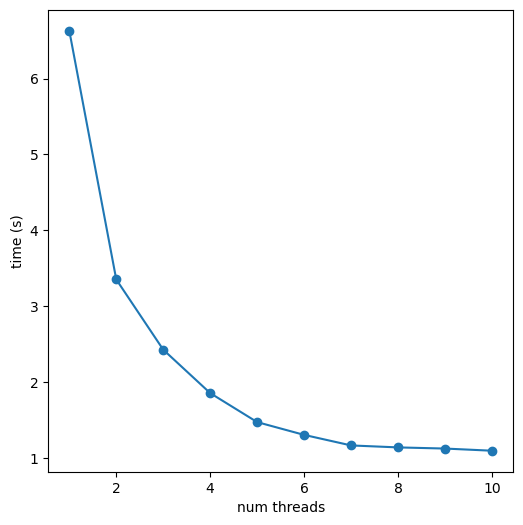

In [16]:
plt.figure(figsize=(6,6))
plt.scatter(times.keys(),times.values());
plt.plot(times.keys(),times.values());
plt.xlabel('num threads')
plt.ylabel('time (s)');

## An important detail to keep in mind

The standard MolSuppliers return the molecules in the order that they were found in the input file, but the MultithreadedMolSuppliers return them in a non-deterministic order (it's the order in which the individual threads end up finishing processing the molecules):

In [17]:
nms_st = [m.GetProp('_Name') for m in Chem.SDMolSupplier(sdfilename) if m is not None]
nms_mt = [m.GetProp('_Name') for m in Chem.MultithreadedSDMolSupplier(sdfilename,numWriterThreads=5) if m is not None]

In [18]:
nms_st[:5]

['ZINC01628630',
 'ZINC71389266',
 'ZINC03847541',
 'ZINC67911113',
 'ZINC41584184']

In [19]:
nms_mt[:5]

['ZINC01628630',
 'ZINC03847541',
 'ZINC71389266',
 'ZINC02386460',
 'ZINC02124320']

So when working with these, instead of tracking results using the index of the molecule, it's better to use a property read from the file, like the `_Name`:

In [20]:
smis = dict([(m.GetProp('_Name'),Chem.MolToSmiles(m)) for m in Chem.MultithreadedSDMolSupplier(sdfilename,numWriterThreads=5) if m is not None])

In [21]:
smis['ZINC00000135']

'OCC(O)COc1ccc(Cl)cc1'

Or you can use the supplier outside of a list comprehension, and take advantage of the `GetLastRecordId()` function, which returns the index+1 of the last molecule read from the input file:

In [22]:
with Chem.MultithreadedSDMolSupplier(sdfilename,numWriterThreads=5) as suppl:
    mol_order = dict([(suppl.GetLastRecordId(),m) for m in suppl if m is not None])

In [23]:
tsuppl = Chem.SDMolSupplier(sdfilename)
for i in range(5):
    print(tsuppl[i].GetProp('_Name'),mol_order[i+1].GetProp('_Name'))

ZINC01628630 ZINC01628630
ZINC71389266 ZINC71389266
ZINC03847541 ZINC03847541
ZINC67911113 ZINC67911113
ZINC41584184 ZINC41584184


If you use this, don't forget the "off by one" nature of the record IDs!